In [1]:
import os, sys

module_path = os.path.abspath(os.path.join("../.."))
sys.path.append(module_path)

## Load datasets

In [2]:
from SLTDataset import SLTDataset


DATASETS = ["LSAT", "RWTH_PHOENIX_2014T", "GSL"]
DATA_DIR = "/mnt/disk3Tb/slt-datasets/"


datasets: dict[str, SLTDataset] = {}
for dataset in DATASETS:
    datasets[dataset] = SLTDataset(
        data_dir=DATA_DIR + dataset,
        split="train",
        input_mode="pose",
        output_mode="text",
    )

Loaded metadata for dataset: LSA-T
Loaded train annotations at /mnt/disk3Tb/slt-datasets/LSAT/annotations.csv


Validating files: 100%|██████████| 5413/5413 [00:00<00:00, 262483.44it/s]


Missing 6 files out of 5413 (0.11%) from split train

Loaded metadata for dataset: RWTH-PHOENIX-Weather 2014 T: Parallel Corpus of Sign Language Video, Gloss and Translation
Loaded train annotations at /mnt/disk3Tb/slt-datasets/RWTH_PHOENIX_2014T/annotations.csv


Validating files: 100%|██████████| 7096/7096 [00:00<00:00, 269285.51it/s]


Dataset loaded correctly

Loaded metadata for dataset: The Greek Sign Language (GSL) Dataset
Loaded train annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 8821/8821 [00:00<00:00, 265439.04it/s]

Dataset loaded correctly



In [3]:
import pandas as pd

from WordLevelTokenizer import WordLevelTokenizer


def get_tokenizer(dataset: SLTDataset) -> WordLevelTokenizer:
    tokenizer = WordLevelTokenizer()
    tokenizer.fit(dataset.annotations["text"].tolist())
    return tokenizer


samples: list[tuple[str, str, float, list[int]]] = []
tokenizers = {name: get_tokenizer(dataset) for name, dataset in datasets.items()}

for name, dataset in datasets.items():
    print(f"Processing dataset {name}")
    for i in range(len(dataset)):
        pose, text = dataset.get_item_raw(i)
        token_ids = tokenizers[name].encode(text)
        samples.append((name, text, len(pose), token_ids))
df = pd.DataFrame(samples, columns=["dataset", "text", "pose_length", "token_ids"])
df["token_length"] = df["token_ids"].apply(len)

Processing dataset LSAT
Processing dataset RWTH_PHOENIX_2014T
Processing dataset GSL


In [4]:
df.head()

,dataset,text,pose_length,token_ids,token_length
0,LSAT,mientras trabajábamos para brindarte toda la ...,676,"[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",45
1,LSAT,mi nombre es lucía.,78,"[2, 38, 39, 40, 41, 3]",6
2,LSAT,los avances en las investigaciones de las vacu...,147,"[2, 42, 43, 11, 44, 45, 18, 44, 46, 47, 22, 48...",13
3,LSAT,cuáles son las novedades de la auh.,102,"[2, 49, 50, 44, 51, 18, 9, 52, 3]",9
4,LSAT,los problemas que puede causar mirar el celula...,156,"[2, 42, 53, 54, 55, 56, 57, 22, 58, 59, 9, 60,...",16


In [5]:
df.groupby("dataset").describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

dataset                     GSL         LSAT  RWTH_PHOENIX_2014T
pose_length  count  8821.000000  5407.000000         7096.000000
             mean     99.978687   286.353246          116.594419
             std      78.051631   215.493003           49.859426
             min       6.000000    30.000000           16.000000
             10%      17.000000    91.000000           55.000000
             25%      39.000000   136.000000           83.000000
             50%      88.000000   224.000000          112.000000
             75%     135.000000   370.000000          144.000000
             90%     192.000000   563.000000          182.000000
             95%     252.000000   717.400000          208.000000
             99%     349.800000  1049.700000          259.000000
             max     615.000000  2695.000000          475.000000
token_length count  8821.000000  5407.000000         7096.000000
             mean      6.182746    17.999630           15.962937
             std       2.613097    10.921338            5.983502
             min       3.000000     3.000000            3.000000
             10%       3.000000     7.000000            9.000000
             25%       4.000000    10.000000           12.000000
             50%       6.000000    15.000000           15.000000
             75%       8.000000    23.000000           19.000000
             90%       9.000000    33.000000           24.000000
             95%      11.000000    39.000000           27.000000
             99%      13.000000    52.940000           33.000000
             max      20.000000   113.000000           54.000000

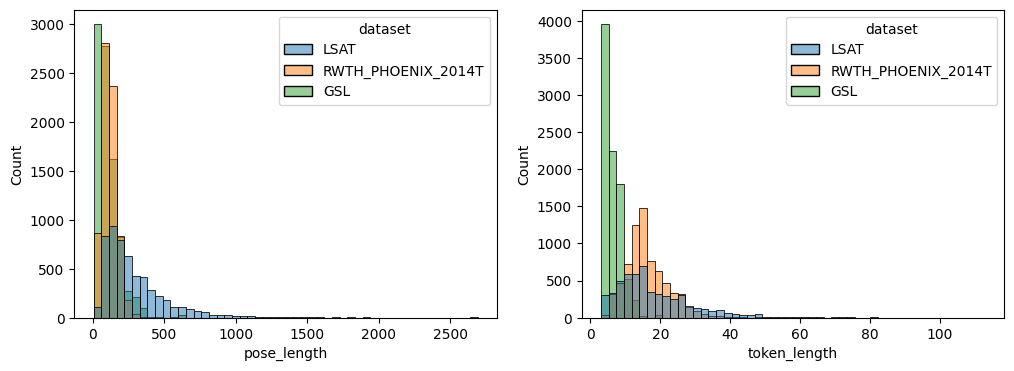

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=df, x="pose_length", hue="dataset", bins=50, ax=axs[0])
sns.histplot(data=df, x="token_length", hue="dataset", bins=50, ax=axs[1])
plt.show()

## Word frequency analysis

Percentage of different sentences over the whole dataset

In [7]:
100 * df.groupby("dataset")["text"].nunique() / df.groupby("dataset")["text"].count()

dataset
GSL                    3.514341
LSAT                  96.301091
RWTH_PHOENIX_2014T    96.575536
Name: text, dtype: float64

In [8]:
full_texts = df.groupby("dataset").agg({"token_ids": "sum"})
full_texts["token_ids"] = full_texts["token_ids"].apply(
    lambda tokens: list(filter(lambda token: token != 2 and token != 3, tokens))
)
full_texts["token_ids"].apply(set).apply(len)

dataset
GSL                     473
LSAT                  15664
RWTH_PHOENIX_2014T     2887
Name: token_ids, dtype: int64

In [9]:
full_texts_dfs = {
    dataset: pd.DataFrame(
        {"token": full_texts.loc[dataset, "token_ids"]},
    )
    for dataset in DATASETS
}
token_freqs = {}
for dataset in DATASETS:
    frequency_counts = (
        full_texts_dfs[dataset].value_counts().value_counts().sort_index()
    )
    token_freqs[dataset] = 100 * frequency_counts / frequency_counts.sum()

token_freqs_df = pd.DataFrame(token_freqs)
token_freqs_df.head()

,LSAT,RWTH_PHOENIX_2014T,GSL
count,,,
1,61.861593,37.305161,3.805497
2,14.881256,12.123311,0.634249
3,6.690501,6.823692,NaN
4,3.696374,4.641496,0.211416
5,2.323800,3.463803,0.422833


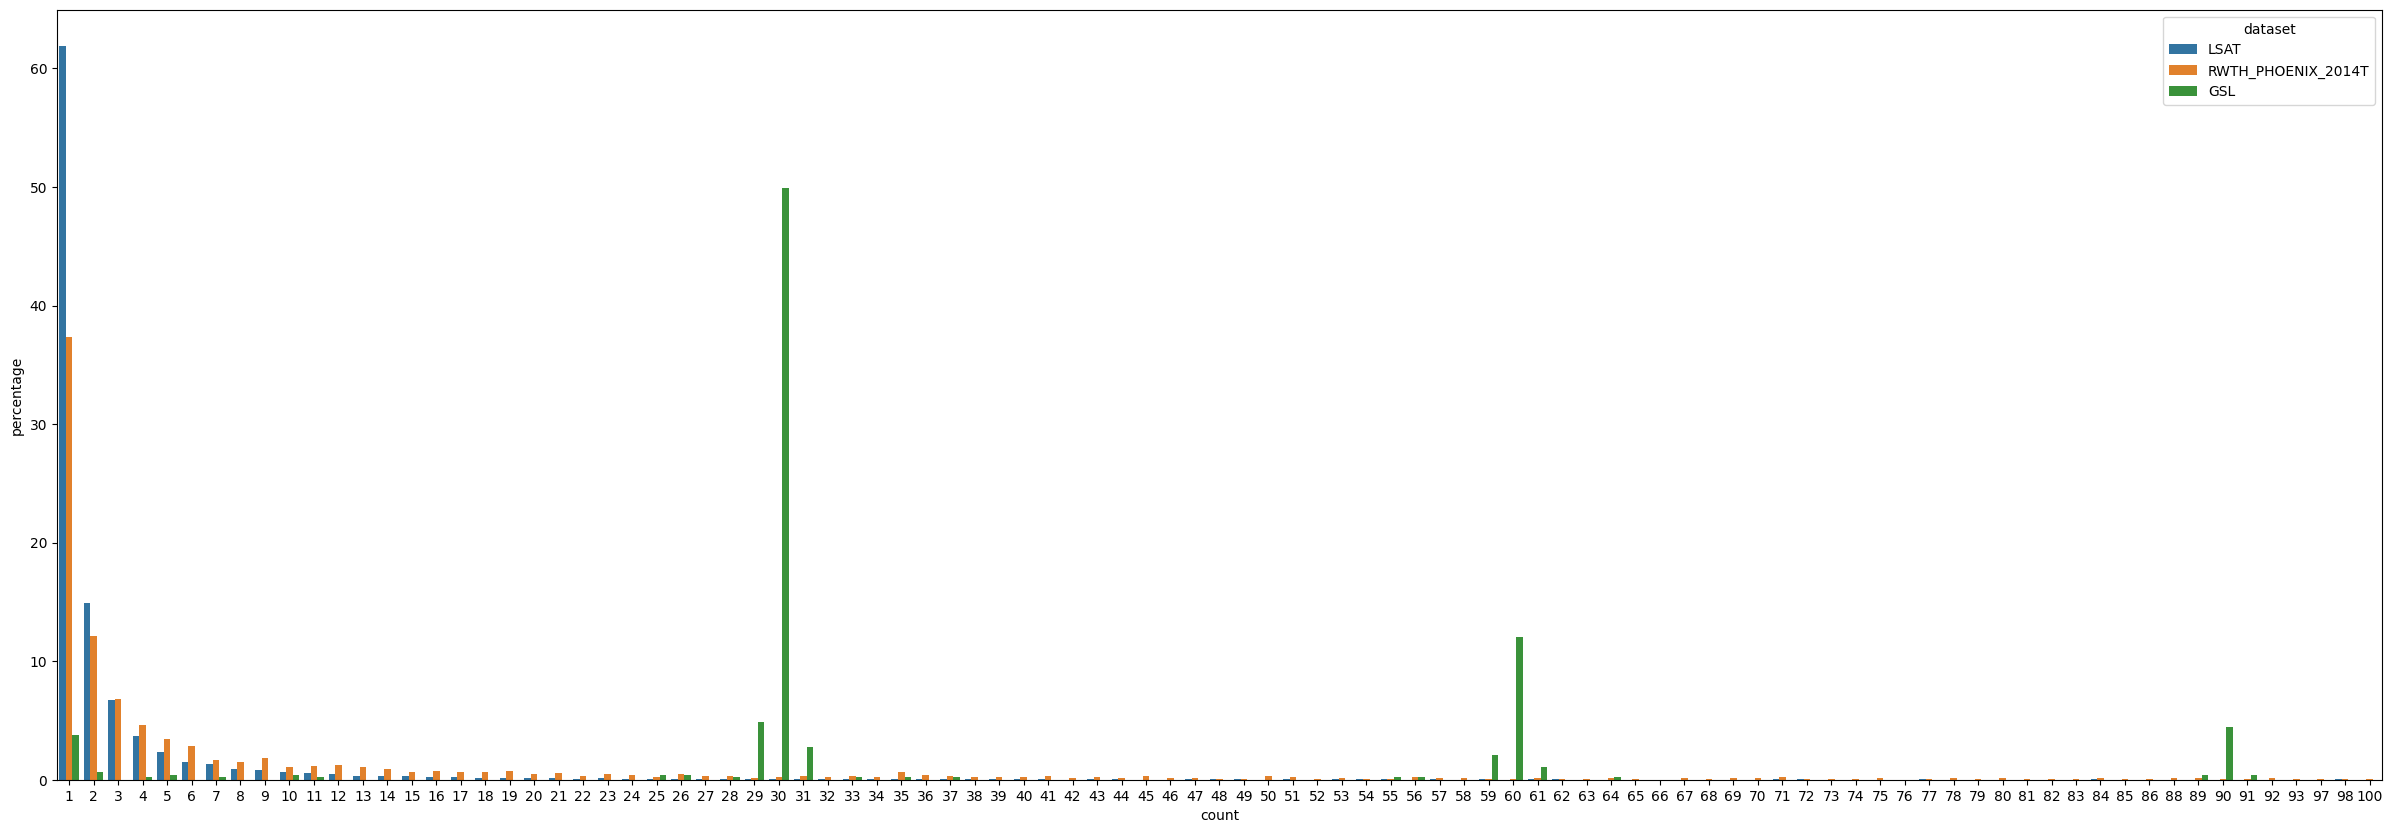

In [10]:
TO_PLOT = 95
token_freqs_top = (
    token_freqs_df[:TO_PLOT].reset_index().rename(columns={"index": "count"})
)
token_freqs_top_melted = token_freqs_top.melt(
    id_vars="count", var_name="dataset", value_name="percentage"
)

plt.figure(figsize=(30, 10))
sns.barplot(x="count", y="percentage", hue="dataset", data=token_freqs_top_melted)
plt.show()